# AED & EEG

## Install libraries

In [1]:
%%capture
# Install ieegpy toolbox directly from github
# !pip install git+https://github.com/ieeg-portal/ieegpy.git
from ieeg.auth import Session
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matlab.engine
# Python Imports
import math
import os
# Scipy Imports
from scipy import stats, io
# My imports
from ieeg_utils import *
from signal_processing import *
from plotting import *

## Load data

In [2]:
# Load HUP_implant_dates.xlsx
patients_df = pd.read_excel("./data/HUP_implant_dates.xlsx")
patients_df.head()

,ptID,IEEG_Portal_Number,Implant_Date,implant_time,Explant_Date,weight_kg
0,225,HUP225_phaseII,2021-10-18,07:15:00,2021-10-26 17:30:00,58.5
1,224,HUP224_phaseII,2021-10-13,07:15:00,2021-10-20 00:00:00,85.5
2,223,HUP223_phaseII,2021-09-29,07:15:00,2021-10-08 08:21:00,101.4
3,221,HUP221_phaseII,2021-08-16,07:15:00,2021-08-23 00:00:00,124.3
4,219,HUP219_phaseII,2021-07-12,07:15:00,2021-07-16 08:18:00,101.6


In [3]:
# Load aed_list.csv
aed_df = pd.read_csv("./data/aed_list.csv")
# Lowercase AED
aed_df["AED"] = aed_df["AED"].str.lower()
aed_df

,AED,Generic,Abbreviation
0,acetazolamide,acetazolamide,ACZ
1,ativan,lorazepam,LZP
2,banzel,rufinamide,RUF
3,brivaracetam,brivaracetam,BRI
4,carbamazepine,carbamazepine,CBZ
...,...,...,...
81,zarontin,ethosuximide,ETX
82,zonegran,zonisamide,ZNS
83,zonisamide,zonisamide,ZNS
84,aptiom,eslicarbazepine,xxx


In [4]:
# Load aed_ref_ranges.xlsx from ./data/
aed_ref_ranges_df = pd.read_excel("./data/aed_ref_ranges.xlsx")
# Lowercase Drug column
aed_ref_ranges_df["Drug"] = aed_ref_ranges_df["Drug"].str.lower()
# show unique units
print(aed_ref_ranges_df["Unit"].unique())
# mg/L and ug/mL are the same
# If Unit is ng/mL, convert to ug/mL
aed_ref_ranges_df.loc[aed_ref_ranges_df["Unit"] == "ng/mL", "Min"] = (
    aed_ref_ranges_df["Min"] / 1000
)
aed_ref_ranges_df.loc[aed_ref_ranges_df["Unit"] == "ng/mL", "Max"] = (
    aed_ref_ranges_df["Max"] / 1000
)
# Add a column that takes the average of Min and Max
aed_ref_ranges_df["Avg"] = (aed_ref_ranges_df["Min"] + aed_ref_ranges_df["Max"]) / 2
aed_ref_ranges_df

['mg/L' 'ug/mL' 'ng/mL']


,Drug,Min,Max,Unit,Avg
0,levetiracetam,12.00,46.00,mg/L,29.000
1,carbamazepine,4.00,10.00,mg/L,7.000
2,oxcarbazepine,3.00,35.00,ug/mL,19.000
3,clobazam,0.03,0.30,ng/mL,0.165
4,n-desmethylclobazam,0.30,3.00,ng/mL,1.650
5,topiramate,5.00,20.00,mg/L,12.500
6,valproic acid,50.00,125.00,ug/mL,87.500
7,lacosamide,1.00,10.00,ug/mL,5.500
8,felbamate,30.00,60.00,ug/mL,45.000
9,lamotrigine,2.50,15.00,mg/L,8.750


In [5]:
patient_ids = patients_df.ptID.to_numpy()
patient_weights = patients_df.weight_kg.to_numpy()
assert len(patient_ids) == len(patient_weights) == 80
len(patient_ids)

80

In [6]:
# Create a mapping between patient ids and the index of the patient in the patients_df dataframe.
patient_id_to_index = {}
for i, patient_id in enumerate(patient_ids):
    patient_id_to_index[patient_id] = i

In [7]:
ieeg_offset_row1_df = pd.read_excel("data/ieeg_offset/row_1.xlsx", header=None)
ieeg_offset_row2_df = pd.read_excel("data/ieeg_offset/row_2.xlsx", header=None)
ieeg_offset_row3_df = pd.read_excel("data/ieeg_offset/row_3.xlsx", header=None)

In [8]:
# Load rid_hup_table.csv from ./data/
rid_hup_table_df = pd.read_csv("./data/rid_hup_table.csv")
# Drop the t3_subject_id and ieegportalsubjno columns
rid_hup_table_df = rid_hup_table_df.drop(columns=["t3_subject_id", "ieegportalsubjno"])
rid_hup_table_df

,record_id,hupsubjno
0,623,35
1,624,36
2,625,37
3,626,38
4,627,39
...,...,...
212,534,250
213,923,251
214,918,252
215,864,253


In [9]:
# Load master_elecs.csv from ./data/
master_elecs_df = pd.read_csv("./data/master_elecs.csv")

# only take the numbers in rid column
master_elecs_df["rid"] = master_elecs_df["rid"].str.extract("(\d+)", expand=False)
master_elecs_df["rid"] = master_elecs_df["rid"].astype(int)

master_elecs_df

,rid,name,mni_x,mni_y,mni_z,mm_x,mm_y,mm_z,vox_x,vox_y,vox_z,label,soz,resected,spike_rate,engel
0,13,LST01,-34.416,-30.306,14.106,-34.6751,-0.42270,-39.4603,80.6116,106.5480,64.5941,left inferior temporal,False,False,1.091902,1.0
1,13,LST02,-40.867,-27.839,13.436,-43.0088,2.37777,-40.9321,72.0779,109.4150,63.1223,left inferior temporal,False,False,1.091902,1.0
2,13,LST03,-46.339,-24.613,16.392,-50.0126,5.26941,-35.3090,64.9060,112.3760,68.7455,EmptyLabel,False,False,1.419472,1.0
3,13,LST04,-46.326,-21.682,21.294,-49.9003,7.50003,-25.8205,65.0210,114.6600,78.2339,left middle temporal,False,False,0.655141,1.0
4,13,MST01,4.300,-67.361,16.011,15.2559,-41.60630,-33.6340,131.7410,64.3756,70.4205,right lingual,True,False,3.439490,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14212,785,RB08,55.240,-24.519,-12.397,54.7706,-22.78030,-19.5040,154.2550,114.2730,136.7560,EmptyLabel,False,NaN,0.369914,1.0
14213,785,RB09,60.019,-26.497,-11.675,58.9395,-25.23490,-19.5579,159.1350,111.9920,136.6960,EmptyLabel,False,NaN,0.665845,1.0
14214,785,RB10,65.500,-28.008,-9.952,63.7847,-27.57940,-18.5976,164.7520,109.9030,137.7640,right middle temporal,False,NaN,4.586930,1.0
14215,785,RB11,70.279,-29.985,-9.230,67.9536,-30.03410,-18.6515,169.6320,107.6220,137.7040,right middle temporal,False,NaN,2.071517,1.0


There are 80 patients.

In [10]:
frequencies = [(50, 75), (75, 100), (100, 125), (125, 150), (150, 175), (175, 200)]

In [29]:
def create_pwd_file(username, password, fname=None):
    if fname is None:
        fname = "{}_ieeglogin.bin".format(username[:3])
    with open(fname, "wb") as f:
        f.write(password.encode())
    print("-- -- IEEG password file saved -- --")


create_pwd_file("dma", "mycqEv-pevfo4-roqfan")

-- -- IEEG password file saved -- --


In [30]:
with open("dma_ieeglogin.bin", "r") as f:
    session = Session("dma", f.read())

In [31]:
frequencies = [(50, 75), (75, 100), (100, 125), (125, 150), (150, 175), (175, 200)]

In [14]:
eng = matlab.engine.start_matlab()
nina_path = eng.genpath("/Volumes/USERS/nghosn3/Pioneer/spikes-AED/aed_dose_modeling")
eng.addpath(nina_path, nargout=0)

In [ ]:
get_aed_curve_kg_res = eng.get_aed_curve_kg(patient_ids, patient_weights, nargout=4)

In [32]:
dose_curves_res = get_aed_curve_kg_res[0]
tHr_res = get_aed_curve_kg_res[1]
med_names_res = get_aed_curve_kg_res[3]

In [33]:
patient_idx = 1

In [34]:
dose_curves_res[patient_idx][0]

matlab.double([[0.0,1.7597445585735751,3.410591533799846,4.959104989743374,6.411453606293728,7.773434494534884,9.05049557763258,10.247756623643347,11.370029011444704,12.421834306095008,13.407421715335069,14.330784494624318,15.195675364044826,16.00562099659194,16.76393563378494,17.473733881162417,18.137942733060672,18.759312873098082,19.340429293992223,19.8837212777086,20.391471774470528,20.86582621683878,21.30880080288869,21.722290280462822,22.108075262551203,22.46782910204084,22.803124352375285,23.115438839066293,23.406161365497365,23.67659707504692,23.927972490232264,24.161440248328457,24.378083551744446,24.578920350337658,24.764907271813254,24.936943315381875,25.095873322935528,25.24249124114258,25.377543187055423,25.50173032906598,25.6157115943313,25.720106213121472,25.815496109912694,25.902428150456494,25.981416253500175,26.05294337531103,26.117463374665768,26.175402765505147,26.227162364020163,26.273118836528493,26.31362615411699,26.34901695966598,26.379603852532995,26.4056805958

In [35]:
np.array(tHr_res[patient_idx][0]).flatten()

array([  9.03333333,   9.05000162,   9.06666991, ..., 180.38333009,
       180.39999838, 180.41666667])

In [36]:
med_names_res[patient_idx]

['levetiracetam', 'lorazepam', 'zonisamide']

In [37]:
devin_path = eng.genpath("/Volumes/USERS/devinma/eeg-AED/matlab")
eng.addpath(devin_path, nargout=0)

In [38]:
good_ids = [224, 223, 204, 202, 196, 190, 188, 187, 180, 178, 177, 174, 170, 169]
good_idx = [patient_id_to_index[id] for id in good_ids]
good_idx

[1, 2, 17, 18, 22, 28, 30, 31, 37, 39, 40, 42, 46, 47]

In [39]:
good_ids[3:4]

[202]

In [40]:
good_idx[3:4]

[18]

In [41]:
ieeg_starts = np.load("./data/ieeg_starts.npy")
ieeg_starts

array([37.58277778, 32.98555556, 35.05583333, 38.7925    , 37.4375    ,
       39.74555556, 42.55333333, 33.71638889, 37.90027778, 37.07416667,
       35.63833333, 38.01916667, 38.24555556, 59.63916667])

## Experiment 1: AED Load vs EEG Phase Synchronization


In [24]:
for frequency in frequencies:
    frequency_range_str = f"{frequency[0]}-{frequency[1]}"
    # Create a folder for the frequency range if it doesn't exist
    if not os.path.exists(f"./results/{frequency_range_str}"):
        os.makedirs(f"./results/{frequency_range_str}")

HUP202 has rid 646
HUP202 has ['HUP202_phaseII'] datasets
['clobazam', 'lacosamide', 'lamotrigine', 'levetiracetam', 'lorazepam']
39
Doses: Start time: 8.4 hr, End time: 244.36666666666667 hr
clobazam
clobazam has ref range 0.16499999999999998 mg/L
adding clobazam to sum_array
plotting clobazam
lacosamide
lacosamide has ref range 5.5 mg/L
adding lacosamide to sum_array
plotting lacosamide
lamotrigine
lamotrigine has ref range 8.75 mg/L
adding lamotrigine to sum_array
plotting lamotrigine
levetiracetam
levetiracetam has ref range 29.0 mg/L
adding levetiracetam to sum_array
plotting levetiracetam
lorazepam
lorazepam has ref range 1 mg/L
Opening HUP202_phaseII, it has offset of 139096.0 seconds
Getting iEEG data for hour 0
Getting iEEG data for hour 1
Getting iEEG data for hour 2
Getting iEEG data for hour 3
Getting iEEG data for hour 4
Getting iEEG data for hour 5
Getting iEEG data for hour 6
Getting iEEG data for hour 7
Getting iEEG data for hour 8
Getting iEEG data for hour 9
Getting i

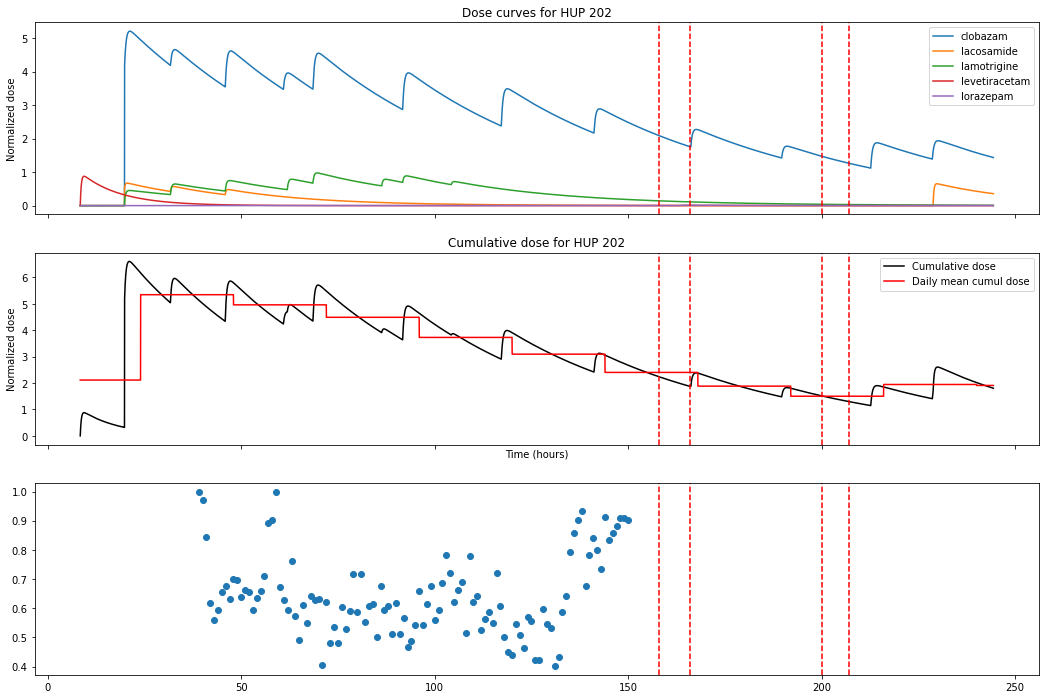

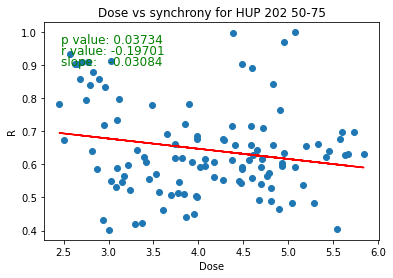

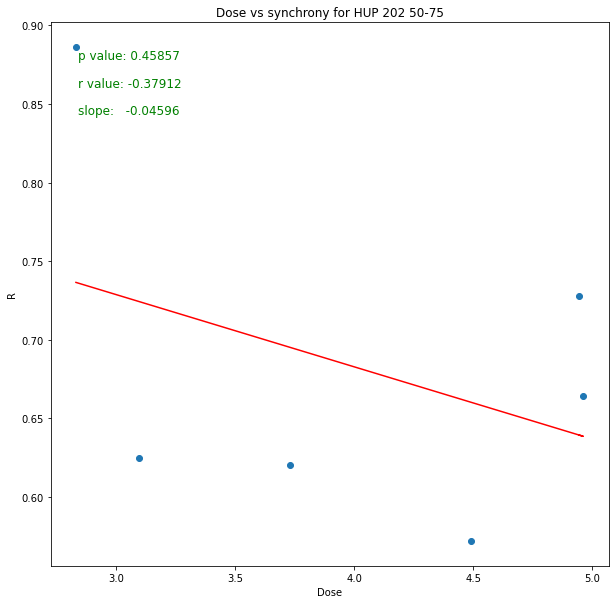

Processing frequency range 75-100
Processing EEG data...


KeyboardInterrupt: 

In [42]:
hourly_dose_all = []
hourly_sync_all = []
patients_processed = []

for i, patient_idx in enumerate(good_idx[3:4]):
    # Get patient id and weight
    patient_id, patient_weight = (
        patient_ids[patient_idx],
        patient_weights[patient_idx],
    )

    #########################################
    # Run matlab script
    #########################################
    aligned_emu_start_time_hrs = round(ieeg_starts[3:4][i])
    seizure_times = np.array(eng.get_seizure_times(f"HUP{patient_id}", nargout=2)[0])

    #########################################
    # Check tables
    #########################################

    if rid_hup_table_df.loc[rid_hup_table_df["hupsubjno"] == patient_id].empty:
        print(f"HUP{patient_id} has no info on rid_hup_table sheet")
        continue

    patient_rid = int(
        rid_hup_table_df.loc[rid_hup_table_df["hupsubjno"] == patient_id].record_id
    )

    print(f"HUP{patient_id} has rid {patient_rid}")

    patient_electrodes_df = master_elecs_df.loc[master_elecs_df["rid"] == patient_rid]

    if patient_electrodes_df.empty:
        print(f"HUP{patient_id} has no info on master electrode sheet")
        continue

    #########################################
    # Get ieeg dataset name
    #########################################

    ieeg_dataset_names = []
    # Check if ieeg_offset_row1_df[patient_idx] is all NaNs
    if ieeg_offset_row1_df[patient_idx].isnull().values.all():
        ieeg_dataset_names = [f"HUP{patient_id}_phaseII"]
    else:
        ieeg_dataset_names = ieeg_offset_row1_df[patient_idx].dropna().to_list()

    print(f"HUP{patient_id} has {str(ieeg_dataset_names)} datasets")

    if len(ieeg_dataset_names) > 1:
        continue

    #########################################
    # Get the useful channels
    #########################################

    dataset_name = ieeg_dataset_names[0]
    ds = session.open_dataset(dataset_name)
    channel_labels = ds.get_channel_labels()
    channel_types_df = check_channel_types(channel_labels)

    seeg_electrodes_df = channel_types_df.loc[(channel_types_df["type"] == "seeg")]
    eeg_electrodes_df = channel_types_df.loc[(channel_types_df["type"] == "eeg")]
    ecog_electrodes_df = channel_types_df.loc[(channel_types_df["type"] == "ecog")]
    ecg_electrodes_df = channel_types_df.loc[(channel_types_df["type"] == "ecg")]

    # Find the rows in patient_electrodes_df that correspond to seeg_electrodes
    seeg_electrodes_df = patient_electrodes_df.loc[
        patient_electrodes_df["name"].isin(seeg_electrodes_df.name.to_numpy(dtype=str))
    ]
    # Find the ones that have label not 'EmptyLabel'
    grey_matter_seeg_electrodes_df = seeg_electrodes_df.loc[
        seeg_electrodes_df["label"] != "EmptyLabel"
    ]

    # Find the indices of the names of the grey matter electrodes in channel_types_df
    grey_matter_seeg_electrodes_indices = channel_types_df.loc[
        channel_types_df["name"].isin(grey_matter_seeg_electrodes_df.name)
    ].copy()  # Added .copy() here to create a new DataFrame

    soz_mapping = grey_matter_seeg_electrodes_df.set_index("name")["soz"].to_dict()
    grey_matter_seeg_electrodes_indices["soz"] = grey_matter_seeg_electrodes_indices[
        "name"
    ].map(soz_mapping)

    all_indices = grey_matter_seeg_electrodes_indices.name.to_numpy(dtype=str)
    soz_indices = grey_matter_seeg_electrodes_indices.loc[
        grey_matter_seeg_electrodes_indices.soz == True
    ].name.to_numpy(dtype=str)
    non_soz_indices = grey_matter_seeg_electrodes_indices.loc[
        grey_matter_seeg_electrodes_indices.soz == False
    ].name.to_numpy(dtype=str)

    #########################################
    # Get AED dose
    #########################################

    # Assign results to variables
    all_dose_curves = dose_curves_res[patient_idx]
    all_tHr = tHr_res[patient_idx]
    all_med_names = med_names_res[patient_idx]

    print(all_med_names)

    assert (
        len(all_dose_curves) == len(all_tHr) == len(all_med_names)
    ), "all_dose_curves, all_tHr, and all_med_names should have the same length"

    # Process numpy arrays
    all_med_names_plot = np.array(all_med_names).flatten()

    tmp = []
    for dose in all_dose_curves:
        dose = np.array(dose).flatten()
        tmp.append(dose)
    all_dose_curves_plot = np.array(tmp, dtype=object)

    tmp = []
    for dose in all_tHr:
        dose = np.array(dose).flatten()
        tmp.append(dose)
    all_tHr_plot = np.array(tmp, dtype=object)

    # Get the last element of each array in all_tHr_plot and test if they're the same
    # They should be the same because they're the same patient
    assert all(
        [all_tHr_plot[i][-1] == all_tHr_plot[0][-1] for i in range(len(all_tHr_plot))]
    ), "The last element of each array in all_tHr_plot should be the same"

    # Construct the time axis
    emu_start_time_hrs = min([all_tHr_plot[i][0] for i in range(len(all_tHr_plot))])
    emu_end_time_hrs = all_tHr_plot[0][-1]
    max_dose_duration_hrs = emu_end_time_hrs - emu_start_time_hrs
    max_length = max([len(all_tHr_plot[i]) for i in range(len(all_tHr_plot))])
    time_axis = np.linspace(emu_start_time_hrs, emu_end_time_hrs, max_length)
    print(aligned_emu_start_time_hrs)
    # Print start and end times in one line
    print(
        f"Doses: Start time: {emu_start_time_hrs} hr, End time: {emu_end_time_hrs} hr"
    )

    daily_df, hourly_df, cumulative_dose_curve, time_axis, ax3, fig = plot_aed_curves(
        all_dose_curves_plot,
        all_med_names_plot,
        all_tHr_plot,
        aed_ref_ranges_df,
        patient_id,
        time_axis,
        seizure_times,
        aligned_emu_start_time_hrs,
    )

    #########################################
    # Get iEEG data
    #########################################

    for dataset_idx, dataset_name in enumerate(ieeg_dataset_names):
        eeg_offset_sec = ieeg_offset_row2_df[patient_idx][dataset_idx]
        eeg_offset_usec, eeg_offset_hrs = eeg_offset_sec * 1e6, int(
            eeg_offset_sec / 3600
        )
        assert (
            eeg_offset_sec > 0
        ), "ieeg_offset_sec should be positive, i.e. iEEG starts after AEDs"

        print(f"Opening {dataset_name}, it has offset of {eeg_offset_sec} seconds")
        # check if aligned_emu_start_time_hrs is an integer

        hourly_eeg = []
        eeg_end_time_hrs = None

        for hour in range(int(max_dose_duration_hrs) + 1):
            print(f"Getting iEEG data for hour {hour}")
            duration_usec = 1.2e8  # 2 minute
            start_time_usec = hour * 3600 * 1e6
            stop_time_usec = start_time_usec + duration_usec

            local_res, sample_rate = get_iEEG_data(
                "dma",
                "dma_ieeglogin.bin",
                dataset_name,
                start_time_usec,
                stop_time_usec,
                select_electrodes=all_indices,
            )

            assert local_res.shape[1] == len(grey_matter_seeg_electrodes_indices)

            # Drop rows that are all NaN
            local_res = local_res.dropna(axis=0, how="any")
            # Check if local_res is empty
            if local_res.empty:
                eeg_end_time_hrs = hour
                break
            else:
                hourly_eeg.append(local_res)

        #########################################
        # Time alignment
        #########################################

        # Create an array starting from aligned_emu_start_time_hrs for the length of processed_hourly_eeg
        eeg_hours = np.arange(0, eeg_end_time_hrs)
        emu_hours = hourly_df.index.values

        emu_hrs_in_consideration = np.arange(
            aligned_emu_start_time_hrs,
            min(emu_hours[-1], (eeg_hours + aligned_emu_start_time_hrs)[-1]),
        )
        eeg_hrs_in_consideration = (
            emu_hrs_in_consideration - (eeg_hours + aligned_emu_start_time_hrs)[0]
        )
        assert len(emu_hrs_in_consideration) == len(
            eeg_hrs_in_consideration
        ), "emu_hrs_in_consideration and eeg_hrs_in_consideration should have the same length"

        for frequency in frequencies:
            frequency_range_str = f"{frequency[0]}-{frequency[1]}"
            print(f"Processing frequency range {frequency_range_str}")

            #########################################
            # Use process_eeg_data to process each column of test_data
            #########################################

            print("Processing EEG data...")
            processed_hourly_eeg = []
            for eeg_df in hourly_eeg:
                local_df = eeg_df.apply(
                    lambda x: process_eeg_data(
                        x, sample_rate, band_pass_freq=frequency
                    ),
                    axis=0,
                )
                processed_hourly_eeg.append(local_df)

            print(f"Length of processed_data: {len(processed_hourly_eeg)}")

            hourly_synchrony = []
            daily_sync = []

            #########################################
            # Calculate synchrony
            #########################################

            print("Calculating Kuramoto order parameter...")
            hourly_synchrony = [
                calculate_kuramoto_order_parameter(eeg_df.T).mean()
                for eeg_df in processed_hourly_eeg
            ]

            #########################################
            # Prepare regression data
            #########################################

            dose_for_regression = hourly_df.loc[emu_hrs_in_consideration][
                "Value"
            ].values
            synchrony_for_regression = np.array(hourly_synchrony)[
                eeg_hrs_in_consideration
            ]
            assert len(dose_for_regression) == len(
                synchrony_for_regression
            ), "dose_for_regression and synchrony_for_regression should have the same length"

            hourly_regression_df = pd.DataFrame(
                {
                    "Hour": emu_hrs_in_consideration,
                    "Dose": dose_for_regression,
                    "Synchrony": synchrony_for_regression,
                }
            )
            hourly_regression_df["Day"] = (hourly_regression_df["Hour"] // 24).astype(
                int
            )
            daily_regression_df = (
                hourly_regression_df.groupby("Day").mean().drop(columns=["Hour"])
            )

            # Plot synchrony vs dose
            ax3.plot(emu_hrs_in_consideration, synchrony_for_regression, "o")

            # Save the figure
            fig.savefig(
                f"./results/{frequency_range_str}/{patient_id}_dose_{frequency[0]}_{frequency[1]}.png"
            )

            # Fit a linear regression model to synchrony_for_regression and dose_for_regression using SciPy
            print("Fitting linear regression model...")
            if len(dose_for_regression) == 0 or len(synchrony_for_regression) == 0:
                print("No data for linear regression")
                continue

            linear_regression_and_plot(
                dose_for_regression,
                synchrony_for_regression,
                patient_id,
                frequency_range_str,
                frequency,
                "hourly",
            )

            # Fit a linear regression model to dose and synchrony using SciPy
            if len(daily_regression_df) == 0:
                print("No data for daily linear regression")
                continue

            hourly_dose_all.append(daily_regression_df["Dose"].values)
            hourly_sync_all.append(daily_regression_df["Synchrony"].values)

            linear_regression_and_plot(
                daily_regression_df["Dose"],
                daily_regression_df["Synchrony"],
                patient_id,
                frequency_range_str,
                frequency,
                "daily",
            )

            patients_processed.append(patient_id)

            plt.show()

    # plot_all_patients(hourly_dose_all, hourly_sync_all, frequency_range_str)

In [53]:
emu_hrs_in_consideration

array([ 39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150])

In [54]:
synchrony_for_regression

array([0.62208894, 0.659322  , 0.44114681, 0.91165264, 0.69867708,
       0.48222578, 0.83291692, 0.54612091, 0.54386027, 0.69817041,
       0.6399159 , 0.50720958, 0.85922381, 0.53738364, 0.6142169 ,
       0.48202869, 0.46279603, 0.67603796, 0.66187815, 0.88019916,
       0.65408917, 0.56116408, 0.60304605, 0.90866109, 0.56957075,
       0.59271625, 0.90967113, 0.59493399, 0.52747822, 0.55654472,
       0.59220275, 0.68643371, 0.90205197, 0.42409029, 0.63584434,
       0.65992445, 0.78400984, 0.71660644, 0.42117728, 0.72147289,
       0.59831171, 0.70880236, 0.58659146, 0.71749706, 0.54669983,
       0.89152653, 0.62070166, 0.53177892, 0.90341466, 0.55314765,
       0.66253973, 0.6906314 , 0.40183947, 0.60739766, 0.99724027,
       0.61550358, 0.43278985, 0.67251577, 0.51623168, 0.50039865,
       0.58632258, 0.62979276, 0.78019318, 0.67625126, 0.64057937,
       0.62148449, 0.59450982, 0.79401035, 0.64265991, 0.99947591,
       0.7633744 , 0.59347951, 0.60659117, 0.57311158, 0.97079

In [51]:
# print the lengths of synchrony_for_regression and emu_hrs_in_consideration
print(len(synchrony_for_regression))
print(len(emu_hrs_in_consideration))

113
112


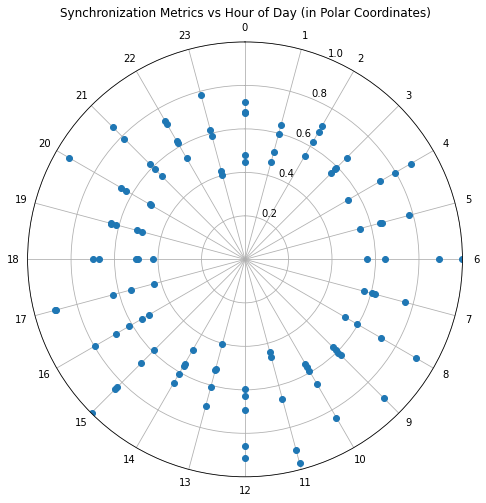

In [57]:
# Assuming emu_hrs_in_consideration and synchrony_for_regression arrays are defined

# Convert the hour to a 24 hour format
emu_hrs_24 = emu_hrs_in_consideration % 24

# Convert the 24 hour format to radians
emu_hrs_radians = (emu_hrs_24 / 24) * (2 * np.pi)

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, polar=True)

# The 0 degree is at 3 o'clock in the plot, so we need to subtract pi/2 to start at 12 o'clock
ax.plot(emu_hrs_radians - np.pi / 2, synchrony_for_regression[:112], "o")

# Set the direction of the plot to clockwise and set 0 degree at the top
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)

# Set the radial limits from 0 to 1
ax.set_ylim(0, 1)

# Set the ticks for each hour
ax.set_xticks(np.linspace(0, 2.0 * np.pi, 24, endpoint=False))

# Set labels for the ticks
ax.set_xticklabels(range(24))

plt.title("Synchronization Metrics vs Hour of Day (in Polar Coordinates)")
plt.show()

## Experiment 2: EEG Phase Synchronization in SOZ vs non-SOZ
**Question:** Are the oserved changes in R were only driven by a subset of channels in the seizure onset zone? We repeat the synchronization analysis for channels in the seizure onset zone only as well as for the channels outside the seizure onset zone.

**Hypothesis:** AED-dependent changes in R are observed in networks encompassing all channels, only channels of the seizure onset zone, and only channels outside the seizure onset zone.

## Playground

In [27]:
for i in range(4):
    if i == 2:
        continue
    print(i)

0
1
3
